# Difference Neural Network (DiffNN)

Deep Learning-based methods for individual recognition of *Calotriton Asper*,
Master's Thesis

Lola Pailler García 1430776

In [ ]:
BASE_FOLDER = '/content/drive/My Drive/'
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Mounted at /content/drive/


In [ ]:
from numpy import array, zeros
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread, imshow
from skimage.transform import resize
from keras.models import Model, Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Input, Lambda,
    Dense, Dropout, Activation, BatchNormalization, MaxPooling2D
)
from keras.losses import binary_crossentropy
from keras.optimizers import SGD, Adam, RMSprop
from keras.regularizers import l2
from keras import regularizers, optimizers, metrics
from keras import backend as K
from sklearn.utils import shuffle

import pandas as pd
import numpy as np
import numpy.random as rng
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils
import keras
import tensorflow as tf
import tensorflow_datasets as tfds

Download data

First excel with correspondencies

In [ ]:
dft = pd.read_excel(BASE_FOLDER + 'TritonesCorrespondencias.xlsx', sheet_name="Todas")
display(dft)
dft.Triton.value_counts()

,Triton,Image,Location,Month,Year,Orientation
0,T0001,IMG_1833_2020,Mascarida,August,2020,U
1,T0001,IMG_1834_2020,Mascarida,August,2020,U
2,T0001,IMG_1835_2020,Mascarida,August,2020,U
3,T0002,IMG_1836_2020,Mascarida,August,2020,U
4,T0002,IMG_1837_2020,Mascarida,August,2020,U
...,...,...,...,...,...,...
1557,L0016,IMG_1571_2021,Torrent de la Muga,July,2021,U
1558,L0016,IMG_1572_2021,Torrent de la Muga,July,2021,U
1559,L0016,IMG_1573_2021,Torrent de la Muga,July,2021,U
1560,L0016,IMG_1574_2021,Torrent de la Muga,July,2021,U


L0016    16
F0003    13
K0019    12
K0002    12
L0002    11
         ..
T0051     2
A0004     2
T0065     2
E0026     2
E0025     2
Name: Triton, Length: 311, dtype: int64

Second cut images with the bellies

In [ ]:
direct = BASE_FOLDER + 'Bellies_error'

imgs, names = [], []
for item in os.listdir(direct):
  img = cv2.imread(os.path.join(direct, item))
  imgs.append(img)
  names.append(item)

Data Preprocessing (create dictionary for correspondencies between images and newt id's)

In [ ]:
names = [sub.replace('.jpg', '') for sub in names]

# create dictionary
dictionary = {}
for i, im in enumerate(imgs):
  dictionary[names[i]] = im

# Create dictionary of dictionaries
dictionary_names = (dft.groupby('Triton')
       .apply(lambda x: dict(x['Image']))
       .to_dict())

In [ ]:
tritones, ims = [], []
for i, name in enumerate(names):
  for triton, images in dictionary_names.items():
    for key in images:
      if images[key] == name:
          tritones.append(triton)
          ims.append(imgs[i])

We created a function to make random difference pairs (negative and positives).
Two negatives for each one positive

In [ ]:
def make_difference_pairs(images, labels):
  diffImages, pairLabels = [],[]
  numClasses = len(np.unique(labels))
  labels = np.array(labels)
  idx = [np.where(labels == i)[0] for i in np.unique(labels)] # index for the same images

  for idxA in range(len(images)):
    currentImage = images[idxA]
    label = labels[idxA]

    ix = list(np.unique(labels)).index(label)
    filtered_idx = [x for x in idx[ix] if x != idxA] # We remove the same photo (black ones)
    idxB = np.random.choice(filtered_idx)
    posImage = images[idxB]
    diffImages.append([currentImage-posImage])
    pairLabels.append([1])

    negIdx = np.where(labels != label)[0]
    negIdxrandom = np.random.choice(negIdx, size=2, replace=False)

    negImage = images[negIdxrandom[0]]
    diffImages.append([currentImage-negImage])
    pairLabels.append([0])

    negImage1 = images[negIdxrandom[1]]
    diffImages.append([currentImage-negImage1])
    pairLabels.append([0])

    diffImages1 = np.squeeze(diffImages)
    pairLabels1 = np.squeeze(pairLabels)

    diffImages1 =  np.squeeze(np.array(diffImages1))
    pairLabels1 =  np.squeeze(np.array(pairLabels1))
  return (diffImages1, pairLabels1)

We define the images as X and the id's as Y

In [ ]:
X = ims
Y = tritones
X1 = np.stack(ims, axis=0)
Y1 = np.array(tritones)

Split into train, val and test the newts to create pairs of new newts in each split (60%, 20% and 20%)

In [ ]:
Yunique = np.unique(Y)
np.random.seed(666)
np.random.shuffle(Yunique)
Yunique_train, Yunique_val, Yunique_test = np.split(Yunique, [int(.6*len(Yunique)), int(.8*len(Yunique))])

We check the samples sizes, approximately must by (186, 62 and 63)

In [ ]:
len(Yunique_train), len(Yunique_val), len(Yunique_test)

(186, 62, 63)

Now, we create search the correspondances of the newts labels in the images

In [ ]:
indx_train = np.where(np.isin(Y1, Yunique_train))
indx_val = np.where(np.isin(Y1, Yunique_val))
indx_test = np.where(np.isin(Y1, Yunique_test))

In [ ]:
Xtrain = X1[indx_train]; Ytrain = Y1[indx_train]
Xval = X1[indx_val]; Yval = Y1[indx_val]
Xtest= X1[indx_test]; Ytest = Y1[indx_test]

In [ ]:
len(Xtrain), len(Xval), len(Xtest)

(936, 319, 305)

In [ ]:
Xdiff_train, Ydiff_train = make_difference_pairs(Xtrain, Ytrain)
Xdiff_val, Ydiff_val = make_difference_pairs(Xval, Yval)
Xdiff_test, Ydiff_test = make_difference_pairs(Xtest, Ytest)

In [ ]:
print(pd.DataFrame(Ydiff_train).value_counts())
print(pd.DataFrame(Ydiff_val).value_counts())
print(pd.DataFrame(Ydiff_test).value_counts())

0    1872
1     936
dtype: int64
0    638
1    319
dtype: int64
0    610
1    305
dtype: int64


We shuffle again

In [ ]:
# train
shuffle_index = np.random.permutation(len(Xdiff_train))
Xdiff_train = Xdiff_train[shuffle_index]
Ydiff_train = Ydiff_train[shuffle_index]

In [ ]:
# val
shuffle_index = np.random.permutation(len(Xdiff_val))
Xdiff_val = Xdiff_val[shuffle_index]
Ydiff_val = Ydiff_val[shuffle_index]

In [ ]:
# test
shuffle_index = np.random.permutation(len(Xdiff_test))
Xdiff_test = Xdiff_test[shuffle_index]
Ydiff_test = Ydiff_test[shuffle_index]

Correct the image size

In [ ]:
# Correct the image size
Xdiff_train = Xdiff_train/256.0
Xdiff_val = Xdiff_val/256.0
Xdiff_test = Xdiff_test/256.0

Function to visualize pairs and their labels

In [ ]:
def visualize_differences(diffs, labels, to_show=4, num_col=2, predictions=None, test=False):
  num_row=to_show // num_col if to_show // num_col != 0 else 1
  to_show = num_row*num_col

  # Plot the images
  fig, axes = plt.subplots(num_row, num_col, figsize=(2, 4))
  for i in range(to_show):
    if num_row == 1:
      ax = axes[i % num_col]
    else:
      ax = axes[i // num_col, i % num_col]

    ax.imshow(tf.concat([diffs[i]], axis=1), cmap="gray")
    ax.set_axis_off()
    if test:
      ax.set_title(" {}|{:.3f} ".format(labels[i], predictions[i][0]))
    else:
      ax.set_title("Y: {}".format(labels[i]))
  if test:
    plt.tight_layout(rect=(0, 0, 1.9, 1.9))
  else:
    plt.tight_layout(rect=(0, 0, 1.5, 1.5))
  plt.show()

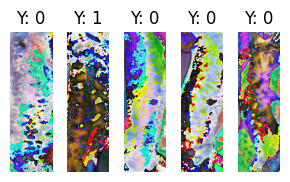

In [ ]:
visualize_differences(Xdiff_train, Ydiff_train, to_show=5, num_col=5)

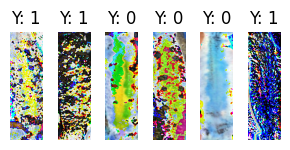

In [ ]:
visualize_differences(Xdiff_val, Ydiff_val, to_show=6, num_col=6)

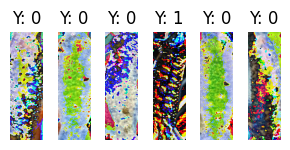

In [ ]:
visualize_differences(Xdiff_test, Ydiff_test, to_show=6, num_col=6)

### Difference Neural Network Structure

In [ ]:
input_shape=(200, 60, 3)
left_input=Input(input_shape)

model = Sequential()
model.add(Conv2D(32, (3, 3),
                activation='relu',
                input_shape=input_shape,
                kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3),
                 activation='relu',
                 kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3),
                 activation='relu',
                 kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D())
model.add(Conv2D(256, (3, 3),
                 activation='relu',
                 kernel_regularizer=l2(2e-4)))
model.add(Flatten())
model.add(Dense(311, activation='sigmoid',
                kernel_regularizer=l2(1e-3)))

encoded_l=model(left_input)

pred = Dense(1, activation='sigmoid')(encoded_l)
diff_net = Model(inputs=left_input, outputs=pred)

optimizer = Adam(0.00006)

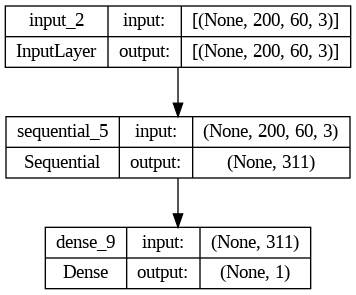

In [ ]:
from keras.utils import plot_model
plot_model(diff_net, to_file='DifferenceNetwork.png', show_shapes=True)

In [ ]:
"""
def contrastive_loss(y_true, y_pred):
    y_true_float = K.cast(y_true, dtype=tf.float32)
    margin = K.constant(1.0, dtype=y_pred.dtype)
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean((1 - y_true_float) * square_pred + y_true_float * margin_square)
"""

Define function to plot the metrics of the network

In [ ]:
def metrics_plot(mod_cnn):
  fig, axs = plt.subplots(2, 2)
  # Accurary
  axs[0, 0].plot(mod_cnn.history['auc_4'])
  axs[0, 0].plot(mod_cnn.history['val_auc_4'])
  axs[0, 0].set(ylabel='AUC')
  # axs[0, 0].xlabel('epoch')

  # Loss
  axs[0, 1].plot(mod_cnn.history['loss'])
  axs[0, 1].plot(mod_cnn.history['val_loss'])
  axs[0, 1].set(ylabel='Constrastive Loss')
  # axs[0, 1].xlabel('epoch')

  # Precission
  axs[1, 0].plot(mod_cnn.history['precision_4'])
  axs[1, 0].plot(mod_cnn.history['val_precision_4'])
  axs[1, 0].set(ylabel='Precision')
  # axs[1, 0].xlabel('epoch')

  # Recall
  axs[1, 1].plot(mod_cnn.history['recall_4'])
  axs[1, 1].plot(mod_cnn.history['val_recall_4'])
  axs[1, 1].set(ylabel='Recall')
  # axs[1, 1].xlabel('epoch')

  plt.figlegend(['Train', 'Validation'], loc='lower center', ncol=2)
  plt.show()

Compile the Difference Network

In [ ]:
optimizer = Adam(0.00006)
diff_net.compile(loss=keras.losses.BinaryCrossentropy(), optimizer=optimizer,
                    metrics=[keras.metrics.AUC(), keras.metrics.Precision(), keras.metrics.Recall()])
diff_net.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 60, 3)]      0         
                                                                 
 sequential_5 (Sequential)   (None, 311)               5496759   
                                                                 
 dense_9 (Dense)             (None, 1)                 312       
                                                                 
Total params: 5497071 (20.97 MB)
Trainable params: 5497071 (20.97 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Apply DiffNN structure to training and validation data

In [ ]:
history = diff_net.fit(
    x=Xdiff_train,
    y=Ydiff_train,
    epochs=30,
    batch_size=16,
    validation_data = (Xdiff_val, Ydiff_val)
    )

Epoch 1/30
176/176 [==============================] - 110s 617ms/step - loss: 1.0094 - auc_4: 0.7674 - precision_4: 0.7654 - recall_4: 0.3451 - val_loss: 0.7914 - val_auc_4: 0.8202 - val_precision_4: 0.8543 - val_recall_4: 0.5329
Epoch 2/30
176/176 [==============================] - 110s 626ms/step - loss: 0.6697 - auc_4: 0.8761 - precision_4: 0.8040 - recall_4: 0.6485 - val_loss: 0.6525 - val_auc_4: 0.8418 - val_precision_4: 0.7863 - val_recall_4: 0.6458
Epoch 3/30
176/176 [==============================] - 108s 614ms/step - loss: 0.5728 - auc_4: 0.8880 - precision_4: 0.7898 - recall_4: 0.6784 - val_loss: 0.5705 - val_auc_4: 0.8689 - val_precision_4: 0.8471 - val_recall_4: 0.6426
Epoch 4/30
176/176 [==============================] - 109s 618ms/step - loss: 0.5013 - auc_4: 0.9061 - precision_4: 0.8466 - recall_4: 0.7019 - val_loss: 0.5488 - val_auc_4: 0.8861 - val_precision_4: 0.9877 - val_recall_4: 0.5016
Epoch 5/30
176/176 [==============================] - 110s 627ms/step - loss: 0.

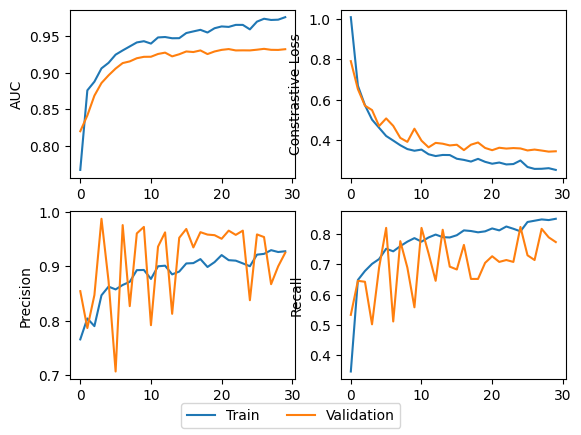

In [ ]:
metrics_plot(history)

Validate the model with the testing set

In [ ]:
res = diff_net.evaluate(Xdiff_test, Ydiff_test)
print("Test loss and test auc:", res)

29/29 [==============================] - 9s 293ms/step - loss: 0.3030 - auc_4: 0.9587 - precision_4: 0.9022 - recall_4: 0.8164
Test loss and test auc: [0.30301517248153687, 0.9586535692214966, 0.9021739363670349, 0.8163934350013733]


In [ ]:
pred = diff_net.predict(Xdiff_test)

29/29 [==============================] - 8s 260ms/step


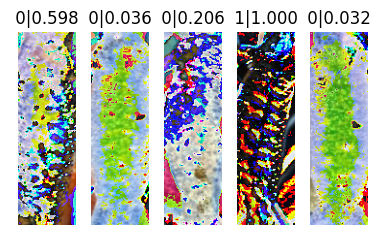

In [ ]:
visualize_differences(Xdiff_test, Ydiff_test, to_show=5, predictions=pred, test=True, num_col=5)

In [ ]:
res_pred_dt = pd.DataFrame({'Y' : Ydiff_test,
                            'Prediction' : np.concatenate(pred)})

Search for the best threshold

In [ ]:
from sklearn.metrics import f1_score, precision_recall_curve, confusion_matrix

def find_best_f1_score(y_true, y_prob):
    # Generate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)

    # Calculate F1 score for different thresholds
    f1_scores = 2 * (precision * recall) / (precision + recall)

    # Find the threshold that maximizes F1 score
    best_threshold = thresholds[np.argmax(f1_scores)]

    # Calculate F1 score using the best threshold
    best_f1_score = f1_score(y_true, y_prob >= best_threshold)

    return best_threshold, best_f1_score

best_threshold, best_f1_score = find_best_f1_score(Ydiff_test, pred)

print(f"Best Threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1_score}")

Best Threshold: 0.33544066548347473
Best F1 Score: 0.8731466227347611


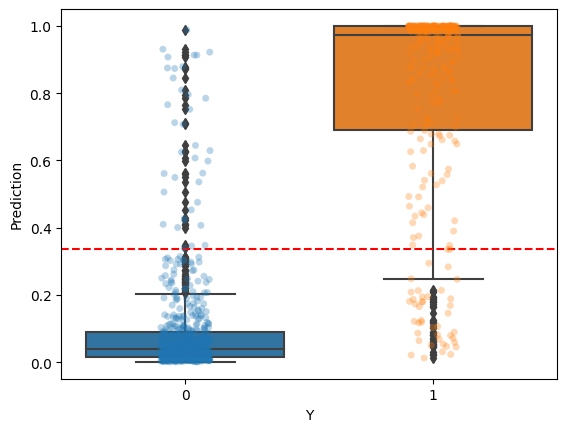

In [ ]:
import matplotlib as plt
import seaborn as sns

ax = sns.boxplot(x='Y', y='Prediction', data=res_pred_dt)
sns.stripplot(data=res_pred_dt, y='Prediction', x='Y', hue='Y',
              alpha=0.3, legend=False)
ax.axhline(y=best_threshold, color="red", linestyle="--", label=f'Best Threshold ({best_threshold:.2f})')

In [ ]:
res_pred_dt['Prediction'] = np.where(res_pred_dt['Prob_prediction'] >= best_threshold, 1, 0)
confusion_matrix(res_pred_dt['Ytest'], res_pred_dt['Prediction'])

array([[573,  37],
       [ 40, 265]])